# FPSO Vessel (Floating Production, Storage and Unloading)
### Task:
To enable the operations of an FPSO, we use sensors to make sure the equipment does not fail. These sensors measure different parameters of the equipment in different setups configurations (preset 1 and preset 2) over time. We want you to investigate one piece of equipment in different time cycles to understand what characteristics and parameters of the sensors might indicate that the equipment is on the verge of failing. To solve this problem, we expect you to answer a few questions regarding the attached dataset:

>1 – Calculate how many times the equipment has failed  

>2 – Categorize equipment failures by setups configurations (preset 1 and preset 2)

>3 – Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)

>4 – Create a model using the technique you think is most appropriate and measure its performance

>5 – Analyze variable importance

#### 1- libraries reading the data
let's start by importing the packages needed for this project, and the data load.

In [1]:
!pip install catboost
!pip install imblearn
!pip install shap 

In [2]:
# Import some libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score, recall_score, accuracy_score


from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import shap

In [3]:
# Read File
df = pd.read_excel('O&G_Equipment_Data.xlsx')
# number of lines and columns
print(f"number of lines: {df.shape[0]} | number of columns: {df.shape[1]}")
df.head()

number of lines: 800 | number of columns: 10


,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


In [5]:
df.dtypes

Cycle            int64
Preset_1         int64
Preset_2         int64
Temperature    float64
Pressure       float64
VibrationX     float64
VibrationY     float64
VibrationZ     float64
Frequency      float64
Fail              bool
dtype: object

In [6]:
df.describe()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,1.988750,4.551250,69.263494,78.997945,73.860275,72.786878,71.866211,68.223449
std,231.0844,0.805875,2.293239,25.536252,32.501834,31.229631,32.739745,27.844616,29.138702
min,1.0000,1.000000,1.000000,2.089354,3.480279,3.846343,10.057744,18.784169,4.380101
25%,200.7500,1.000000,3.000000,51.040134,55.508564,50.752461,48.523982,50.787638,45.861762
50%,400.5000,2.000000,5.000000,65.906716,75.014848,69.394953,65.504770,69.319237,65.664252
75%,600.2500,3.000000,7.000000,80.527220,99.302530,90.195059,94.075572,88.891205,90.097457
max,800.0000,3.000000,8.000000,255.607829,189.995681,230.861142,193.569947,230.951134,178.090303


#### 2- Exploratory data analysis
in this step we will explore our dataset, take some statistical measurements and see the main insights we can find in this data, and thus move on to modeling taking into account our findings with this analysis.



number of equipment failures: 66
number of 'no' equipment failures: 734






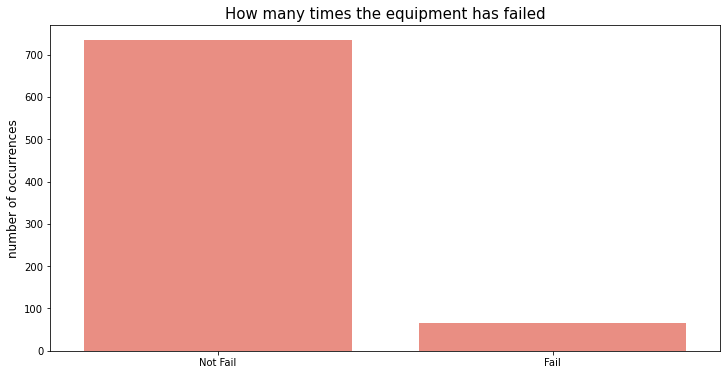

In [7]:
# 1 – Calculate how many times the equipment has failed

print("\n")

fail = len(df[df["Fail"]==True])
not_fail = len(df[df["Fail"]==False])

df['aux_fail'] = ['Fail' if x==True else 'Not Fail' for x in df["Fail"]]

print(f"number of equipment failures: {fail}")
print(f"number of 'no' equipment failures: {not_fail}")

print("\n\n\n")



plt.figure(figsize=(12,6))
sns.countplot(x='aux_fail', data=df, color="salmon")
plt.ylabel("number of occurrences", fontsize=12)
plt.xlabel("", fontsize=12)
plt.title("How many times the equipment has failed", fontsize=15)
plt.show()

### The first insight is observed the discrepant difference between the failure and non-failure values of the Target variable.

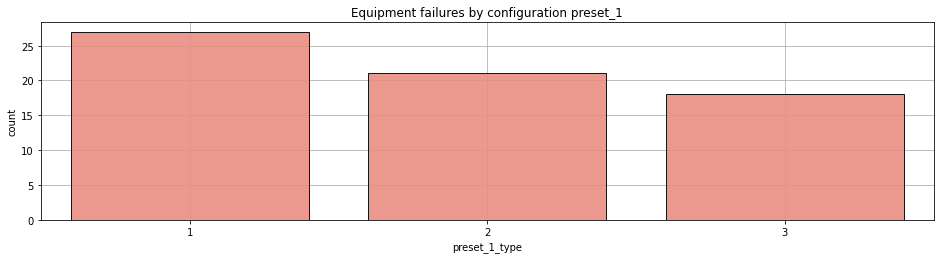

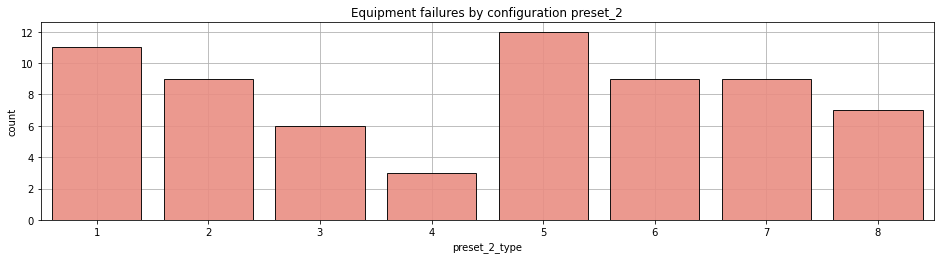

In [8]:
# 2 – Categorize equipment failures by setups configurations (preset 1 and preset 2)

plt.figure(figsize=(16,8))
plt.subplot(2,1,2) 
sns.countplot(x='Preset_1',data=df[df["Fail"]==True], edgecolor="black",linewidth = 1, color = 'salmon', zorder = 3, alpha = 0.9)
plt.grid(True, zorder = 0)
plt.title("Equipment failures by configuration preset_1")
plt.xlabel('preset_1_type')
plt.show()

plt.figure(figsize=(16,8))
plt.subplot(2,1,2) 
sns.countplot(x='Preset_2',data=df[df["Fail"]==True], edgecolor="black",linewidth = 1, color = 'salmon', zorder = 3, alpha = 0.9)
plt.grid(True, zorder = 0)
plt.title("Equipment failures by configuration preset_2")
plt.xlabel('preset_2_type')
plt.show()

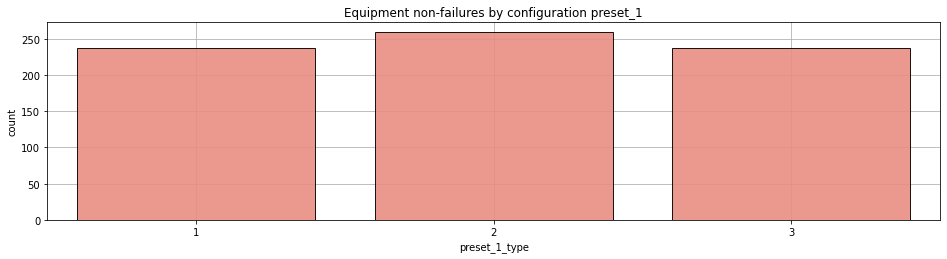

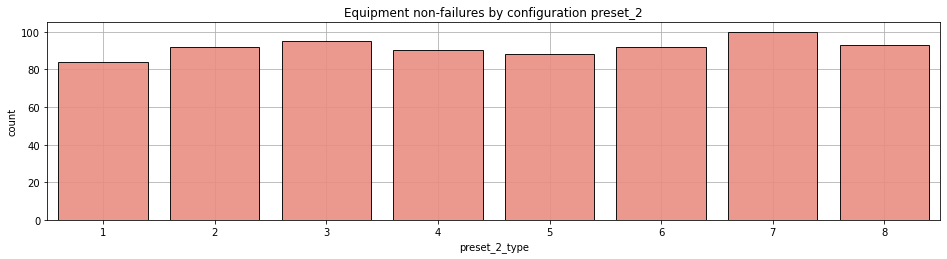

In [9]:
# Looking at the settings of the non-failures

plt.figure(figsize=(16,8))
plt.subplot(2,1,2) 
sns.countplot(x='Preset_1',data=df[df["Fail"]==False], edgecolor="black",linewidth = 1, color = 'salmon', zorder = 3, alpha = 0.9)
plt.grid(True, zorder = 0)
plt.title("Equipment non-failures by configuration preset_1")
plt.xlabel('preset_1_type')
plt.show()

plt.figure(figsize=(16,8))
plt.subplot(2,1,2) 
sns.countplot(x='Preset_2',data=df[df["Fail"]==False], edgecolor="black",linewidth = 1, color = 'salmon', zorder = 3, alpha = 0.9)
plt.grid(True, zorder = 0)
plt.title("Equipment non-failures by configuration preset_2")
plt.xlabel('preset_2_type')
plt.show()

### As expected for the Preset_1 configuration, the type 1 configuration is the least appear, as for the Preset_2 configuration, the type 1 and 5 configuration are the least likely to appear, because it is the settings that as the previous graph would cause the most equipment failures.

Average temperature to fail: 92
Average temperature not to fail: 67




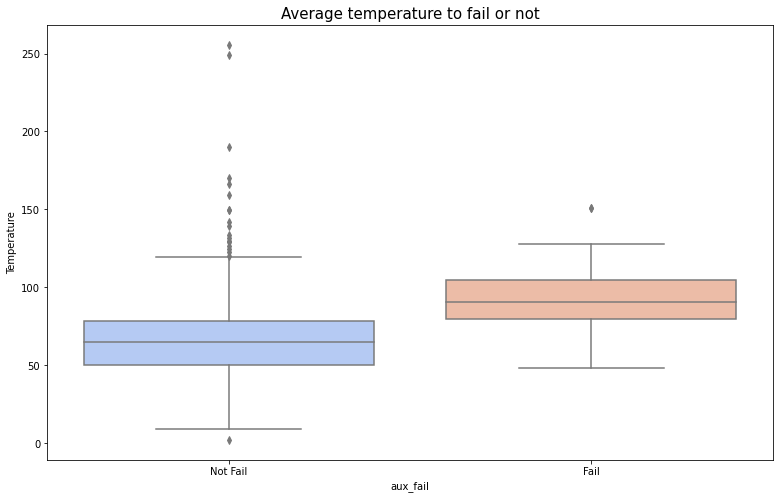

In [10]:
# 3 – Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)
plt.figure(figsize=(13,8))
plt.grid(False)
plt.title('Average temperature to fail or not', fontsize=15)
plt.xlabel(' ')
sns.boxplot(x='aux_fail', y='Temperature', data=df, palette='coolwarm')

# fail_mean
fail_mean = round(np.mean(df[df['Fail']==True]['Temperature']))
no_fail_mean = round(np.mean(df[df['Fail']==False]['Temperature']))

print('Average temperature to fail: {}'.format(fail_mean))
print('Average temperature not to fail: {}'.format(no_fail_mean))
print('\n')

### It is possible to observe that for the equipment to fail, there is a correlation with the high temperature, since the average temperature when the equipment fails is 92º

Average Pressure to fail: 116
Average Pressure not to fail: 76




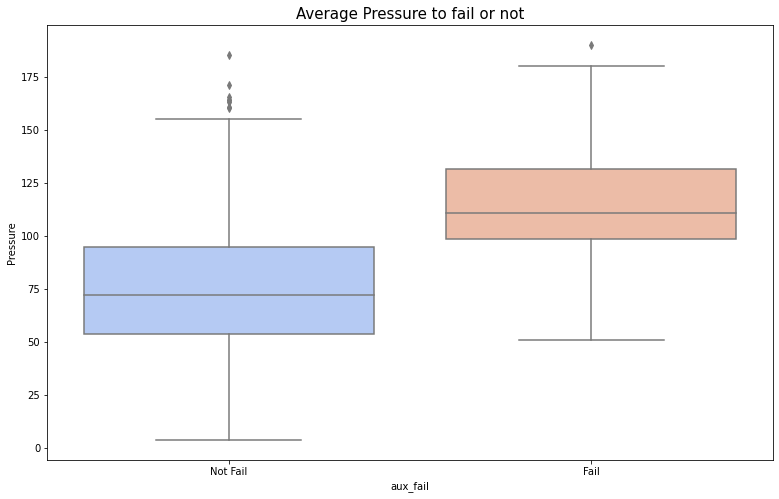

In [11]:
plt.figure(figsize=(13,8))
plt.grid(False)
plt.title('Average Pressure to fail or not', fontsize=15)
plt.xlabel(' ')
sns.boxplot(x='aux_fail', y='Pressure', data=df, palette='coolwarm')

# fail_mean
fail_mean = round(np.mean(df[df['Fail']==True]['Pressure']))
no_fail_mean = round(np.mean(df[df['Fail']==False]['Pressure']))

print('Average Pressure to fail: {}'.format(fail_mean))
print('Average Pressure not to fail: {}'.format(no_fail_mean))
print('\n')

### As in temperature, when observing pressure, it is possible to conclude that for the equipment to fail, there is a correlation with high pressure, since the average pressure when the equipment fails is from 116, to 76 when the equipment does not fail

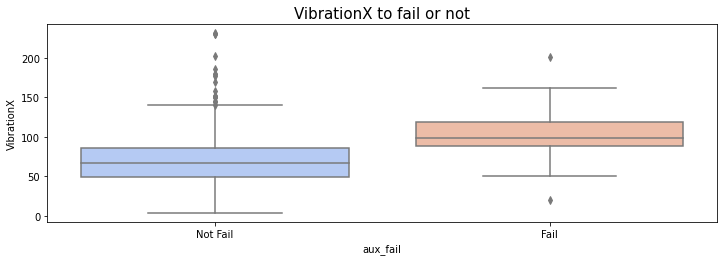

Average VibrationX to fail: 100
Average VibrationX not to fail: 71




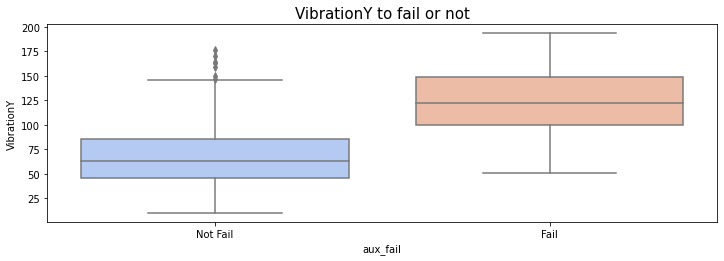

Average VibrationY to fail: 122
Average VibrationY not to fail: 68




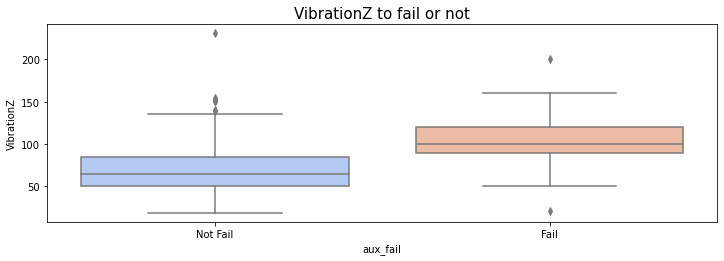

Average VibrationZ to fail: 106
Average VibrationZ not to fail: 69




In [12]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,2) 
plt.grid(False)
plt.title('VibrationX to fail or not', fontsize=15)
plt.xlabel(' ')
sns.boxplot(x='aux_fail', y='VibrationX', data=df, palette='coolwarm')
plt.show()

# fail_mean
fail_mean = round(np.mean(df[df['Fail']==True]['VibrationX']))
no_fail_mean = round(np.mean(df[df['Fail']==False]['VibrationX']))

print('Average VibrationX to fail: {}'.format(fail_mean))
print('Average VibrationX not to fail: {}'.format(no_fail_mean))
print('\n')


plt.figure(figsize=(12,8))
plt.subplot(2,1,2) 
plt.grid(False)
plt.title('VibrationY to fail or not', fontsize=15)
plt.xlabel(' ')
sns.boxplot(x='aux_fail', y='VibrationY', data=df, palette='coolwarm')
plt.show()

# fail_mean
fail_mean = round(np.mean(df[df['Fail']==True]['VibrationY']))
no_fail_mean = round(np.mean(df[df['Fail']==False]['VibrationY']))

print('Average VibrationY to fail: {}'.format(fail_mean))
print('Average VibrationY not to fail: {}'.format(no_fail_mean))
print('\n')


plt.figure(figsize=(12,8))
plt.subplot(2,1,2) 
plt.grid(False)
plt.title('VibrationZ to fail or not', fontsize=15)
plt.xlabel(' ')
sns.boxplot(x='aux_fail', y='VibrationZ', data=df, palette='coolwarm')
plt.show()

# fail_mean
fail_mean = round(np.mean(df[df['Fail']==True]['VibrationZ']))
no_fail_mean = round(np.mean(df[df['Fail']==False]['VibrationZ']))

print('Average VibrationZ to fail: {}'.format(fail_mean))
print('Average VibrationZ not to fail: {}'.format(no_fail_mean))
print('\n')

### Regardless of the type of vibration (x, y or z), the observation is the same, when the vibration increases the chance of failure rises as well.

Average Frequency to fail: 100
Average Frequency not to fail: 65




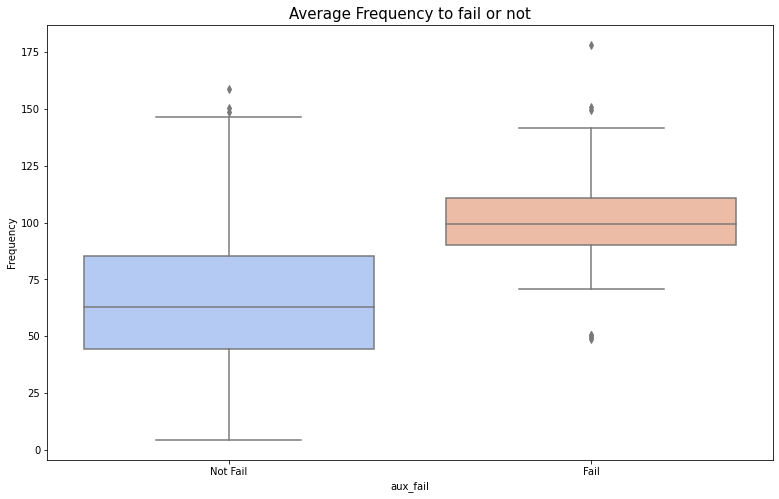

In [13]:
plt.figure(figsize=(13,8))
plt.grid(False)
plt.title('Average Frequency to fail or not', fontsize=15)
plt.xlabel(' ')
sns.boxplot(x='aux_fail', y='Frequency', data=df, palette='coolwarm')

# fail_mean
fail_mean = round(np.mean(df[df['Fail']==True]['Frequency']))
no_fail_mean = round(np.mean(df[df['Fail']==False]['Frequency']))

print('Average Frequency to fail: {}'.format(fail_mean))
print('Average Frequency not to fail: {}'.format(no_fail_mean))
print('\n')

### As in the other cases, the high frequency serves as a warning for a possible failure, with an average failure in the 100 frequency, since, the average of non-failure in the 65 frequency.

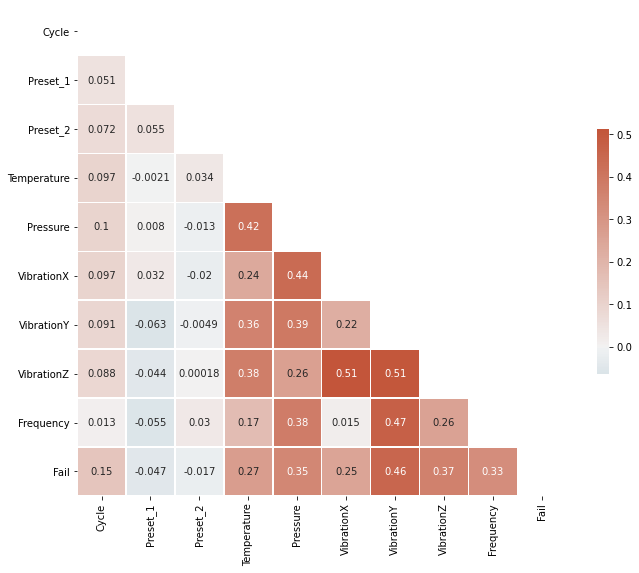

In [14]:
# Pearson correlation chart

print("\n")

corr_celular = df.corr()
mask = np.triu(np.ones_like(corr_celular, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_celular, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

#### 3- Modeling
step that we will model the data to be used in the training of the models

In [15]:
df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,aux_fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False,Not Fail
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False,Not Fail
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False,Not Fail
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False,Not Fail
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False,Not Fail


In [16]:
# 4 – Create a model using the technique you think is most appropriate and measure its performance
del df['aux_fail']
df['Fail'] = [1 if x==True else 0 for x in df["Fail"]]

In [17]:
# Split de Dataset
x = df.drop(['Cycle','Fail'],axis=1)
y = df['Fail']
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size=0.3) # split
sc = StandardScaler()
x_train_s = sc.fit_transform(x_train)
x_test_s = sc.fit_transform(x_test)

#### 4- Predictions
## Test 1
### Run a simple classifier model using StandardScaler just (StandardScaler is used to leave the base staggered between 0 and 1, so the data is a better input to our models)

In [18]:
# Using Random Forest
forest = RandomForestClassifier(random_state=22)
forest.fit(x_train_s,y_train) # train

RandomForestClassifier(random_state=22)

In [19]:
# Analyzing the results
predict_rf = forest.predict(x_test_s)
print(confusion_matrix(y_test,predict_rf))
print(classification_report(y_test,predict_rf))

[[223   4]
 [  7   6]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       227
           1       0.60      0.46      0.52        13

    accuracy                           0.95       240
   macro avg       0.78      0.72      0.75       240
weighted avg       0.95      0.95      0.95       240



## Test 2
### Running a more robust classification model, but using StandardScaler only again.

In [20]:
# CatBoost
cat = CatBoostClassifier(random_state = 222)
cat.fit(x_train_s,y_train)
predict_c = cat.predict(x_test_s)
print('\nF1 Score: ', f1_score(list(y_test.astype(int)), list(predict_c.astype(int))))

Learning rate set to 0.008043
0:	learn: 0.6779914	total: 169ms	remaining: 2m 49s
1:	learn: 0.6658401	total: 178ms	remaining: 1m 28s
2:	learn: 0.6534992	total: 184ms	remaining: 1m 1s
3:	learn: 0.6403886	total: 194ms	remaining: 48.4s
4:	learn: 0.6291172	total: 198ms	remaining: 39.4s
5:	learn: 0.6195522	total: 201ms	remaining: 33.2s
6:	learn: 0.6073292	total: 211ms	remaining: 30s
7:	learn: 0.5978119	total: 241ms	remaining: 29.9s
8:	learn: 0.5851048	total: 251ms	remaining: 27.6s
9:	learn: 0.5741254	total: 268ms	remaining: 26.5s
10:	learn: 0.5637811	total: 275ms	remaining: 24.7s
11:	learn: 0.5541522	total: 282ms	remaining: 23.2s
12:	learn: 0.5447501	total: 288ms	remaining: 21.9s
13:	learn: 0.5351376	total: 291ms	remaining: 20.5s
14:	learn: 0.5257891	total: 294ms	remaining: 19.3s
15:	learn: 0.5174433	total: 297ms	remaining: 18.3s
16:	learn: 0.5081472	total: 301ms	remaining: 17.4s
17:	learn: 0.4994842	total: 304ms	remaining: 16.6s
18:	learn: 0.4896426	total: 307ms	remaining: 15.9s
19:	learn: 

168:	learn: 0.1138616	total: 965ms	remaining: 4.75s
169:	learn: 0.1133083	total: 968ms	remaining: 4.73s
170:	learn: 0.1126191	total: 972ms	remaining: 4.71s
171:	learn: 0.1121468	total: 978ms	remaining: 4.71s
172:	learn: 0.1118416	total: 982ms	remaining: 4.7s
173:	learn: 0.1114223	total: 988ms	remaining: 4.69s
174:	learn: 0.1110071	total: 993ms	remaining: 4.68s
175:	learn: 0.1104107	total: 997ms	remaining: 4.67s
176:	learn: 0.1098455	total: 999ms	remaining: 4.65s
177:	learn: 0.1094342	total: 1s	remaining: 4.63s
178:	learn: 0.1088528	total: 1s	remaining: 4.61s
179:	learn: 0.1083052	total: 1.01s	remaining: 4.59s
180:	learn: 0.1078786	total: 1.01s	remaining: 4.58s
181:	learn: 0.1072497	total: 1.01s	remaining: 4.56s
182:	learn: 0.1068675	total: 1.02s	remaining: 4.54s
183:	learn: 0.1064123	total: 1.02s	remaining: 4.52s
184:	learn: 0.1059618	total: 1.02s	remaining: 4.5s
185:	learn: 0.1054337	total: 1.03s	remaining: 4.49s
186:	learn: 0.1048773	total: 1.03s	remaining: 4.47s
187:	learn: 0.104472

333:	learn: 0.0638143	total: 1.66s	remaining: 3.3s
334:	learn: 0.0636526	total: 1.66s	remaining: 3.29s
335:	learn: 0.0634566	total: 1.66s	remaining: 3.28s
336:	learn: 0.0632219	total: 1.66s	remaining: 3.27s
337:	learn: 0.0631246	total: 1.67s	remaining: 3.27s
338:	learn: 0.0630925	total: 1.67s	remaining: 3.26s
339:	learn: 0.0630506	total: 1.67s	remaining: 3.25s
340:	learn: 0.0629312	total: 1.68s	remaining: 3.24s
341:	learn: 0.0627222	total: 1.68s	remaining: 3.23s
342:	learn: 0.0626122	total: 1.68s	remaining: 3.23s
343:	learn: 0.0623961	total: 1.69s	remaining: 3.22s
344:	learn: 0.0623241	total: 1.69s	remaining: 3.21s
345:	learn: 0.0621717	total: 1.69s	remaining: 3.2s
346:	learn: 0.0619886	total: 1.69s	remaining: 3.19s
347:	learn: 0.0618325	total: 1.7s	remaining: 3.18s
348:	learn: 0.0617161	total: 1.7s	remaining: 3.17s
349:	learn: 0.0616197	total: 1.7s	remaining: 3.16s
350:	learn: 0.0615269	total: 1.71s	remaining: 3.16s
351:	learn: 0.0613813	total: 1.71s	remaining: 3.15s
352:	learn: 0.061

502:	learn: 0.0440032	total: 2.3s	remaining: 2.27s
503:	learn: 0.0438817	total: 2.3s	remaining: 2.27s
504:	learn: 0.0438344	total: 2.31s	remaining: 2.26s
505:	learn: 0.0437456	total: 2.31s	remaining: 2.25s
506:	learn: 0.0436276	total: 2.31s	remaining: 2.25s
507:	learn: 0.0435028	total: 2.32s	remaining: 2.25s
508:	learn: 0.0433965	total: 2.32s	remaining: 2.24s
509:	learn: 0.0433023	total: 2.32s	remaining: 2.23s
510:	learn: 0.0432319	total: 2.33s	remaining: 2.23s
511:	learn: 0.0431330	total: 2.33s	remaining: 2.22s
512:	learn: 0.0430051	total: 2.33s	remaining: 2.22s
513:	learn: 0.0428697	total: 2.34s	remaining: 2.21s
514:	learn: 0.0427921	total: 2.34s	remaining: 2.2s
515:	learn: 0.0427168	total: 2.34s	remaining: 2.2s
516:	learn: 0.0426461	total: 2.35s	remaining: 2.19s
517:	learn: 0.0425751	total: 2.35s	remaining: 2.19s
518:	learn: 0.0424984	total: 2.35s	remaining: 2.18s
519:	learn: 0.0424109	total: 2.35s	remaining: 2.17s
520:	learn: 0.0423125	total: 2.36s	remaining: 2.17s
521:	learn: 0.04

692:	learn: 0.0310404	total: 2.94s	remaining: 1.3s
693:	learn: 0.0309692	total: 2.94s	remaining: 1.3s
694:	learn: 0.0309352	total: 2.96s	remaining: 1.3s
695:	learn: 0.0308392	total: 2.96s	remaining: 1.29s
696:	learn: 0.0307666	total: 2.96s	remaining: 1.29s
697:	learn: 0.0307094	total: 2.97s	remaining: 1.28s
698:	learn: 0.0307002	total: 2.97s	remaining: 1.28s
699:	learn: 0.0306468	total: 2.98s	remaining: 1.27s
700:	learn: 0.0305803	total: 2.98s	remaining: 1.27s
701:	learn: 0.0305322	total: 2.98s	remaining: 1.26s
702:	learn: 0.0305173	total: 2.98s	remaining: 1.26s
703:	learn: 0.0304485	total: 2.99s	remaining: 1.26s
704:	learn: 0.0303851	total: 2.99s	remaining: 1.25s
705:	learn: 0.0303541	total: 2.99s	remaining: 1.25s
706:	learn: 0.0303043	total: 3s	remaining: 1.24s
707:	learn: 0.0302812	total: 3s	remaining: 1.24s
708:	learn: 0.0302096	total: 3s	remaining: 1.23s
709:	learn: 0.0301309	total: 3s	remaining: 1.23s
710:	learn: 0.0300803	total: 3.01s	remaining: 1.22s
711:	learn: 0.0300509	total

870:	learn: 0.0237319	total: 3.58s	remaining: 530ms
871:	learn: 0.0236955	total: 3.59s	remaining: 526ms
872:	learn: 0.0236405	total: 3.59s	remaining: 522ms
873:	learn: 0.0236131	total: 3.59s	remaining: 518ms
874:	learn: 0.0236029	total: 3.6s	remaining: 514ms
875:	learn: 0.0235691	total: 3.6s	remaining: 510ms
876:	learn: 0.0235398	total: 3.6s	remaining: 505ms
877:	learn: 0.0234939	total: 3.61s	remaining: 502ms
878:	learn: 0.0234712	total: 3.62s	remaining: 498ms
879:	learn: 0.0234670	total: 3.62s	remaining: 494ms
880:	learn: 0.0234240	total: 3.63s	remaining: 490ms
881:	learn: 0.0233818	total: 3.63s	remaining: 486ms
882:	learn: 0.0233359	total: 3.66s	remaining: 485ms
883:	learn: 0.0232859	total: 3.67s	remaining: 482ms
884:	learn: 0.0232722	total: 3.67s	remaining: 477ms
885:	learn: 0.0232641	total: 3.68s	remaining: 473ms
886:	learn: 0.0232308	total: 3.69s	remaining: 470ms
887:	learn: 0.0232247	total: 3.69s	remaining: 466ms
888:	learn: 0.0232078	total: 3.7s	remaining: 462ms
889:	learn: 0.02

In [21]:
# Creating functions to analyze the result
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    return(TP, FP, TN, FN)


def compute_metrics(y, y_hat):
    print('Accuracy: ', accuracy_score(y, y_hat))
    print('F1 Score: ', f1_score(y, y_hat))
    print('Avg Precision: ', average_precision_score(y, y_hat))
    print('Avg Recall: ', recall_score(y, y_hat))
    TP, FP, TN, FN = perf_measure(y, y_hat)
    print(' - True Positives: ', TP)
    print(' - False Positives: ', FP)
    print(' - True Negatives: ', TN)
    print(' - False Negatives: ', FN)

In [22]:
# Analyzing the results
compute_metrics(list(y_test.astype(int)), list(predict_c.astype(int)))

Accuracy:  0.9583333333333334
F1 Score:  0.5833333333333334
Avg Precision:  0.3676573426573427
Avg Recall:  0.5384615384615384
 - True Positives:  7
 - False Positives:  4
 - True Negatives:  223
 - False Negatives:  6


## Test 3
### The third and final test, consist of leaving my label, my Target variable with the same size, as we know, there are more negative cases to fail than positive cases, but this may be different using techniques called udersampling (Deselecting Target lines that we have more in our base in order to leave both with the same size (failure and not failure)), or, oversampling (randomly creating lines similar to the Target variable with the smallest amount). This second option usually does better with smaller databases, as is our case, so let's test!

In [23]:
# over
over = SMOTE(random_state=482)
x = df.drop(['Cycle','Fail'],axis=1)
y = df['Fail']
x,y = over.fit_sample(x,y)
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size=0.3) # split

count fails: 734
count not fails: 734


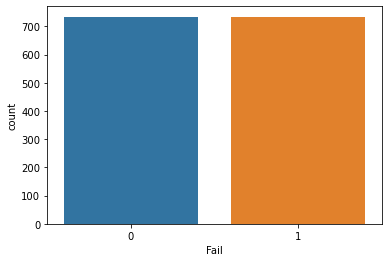

In [24]:
print("count fails: {}".format(int(len(y[y==1]))))
print("count not fails: {}".format(int(len(y[y==0]))))
sns.countplot(x=y)
plt.show()

In [25]:
sc = StandardScaler()
x_train_s = sc.fit_transform(x_train)
x_test_s = sc.fit_transform(x_test)

In [26]:
def teste(n=5):
    forest = RandomForestClassifier(n_estimators=100,max_depth=n,random_state=111)
    forest.fit(x_train_s,y_train)
    predict_rf_over = forest.predict(x_test_s)
    print(n)
    print(confusion_matrix(y_test,predict_rf_over))
    print(classification_report(y_test,predict_rf_over))
    print('\n\n')

In [27]:
[teste(i) for i in range(1,9)]

1
[[187  41]
 [ 21 192]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       228
           1       0.82      0.90      0.86       213

    accuracy                           0.86       441
   macro avg       0.86      0.86      0.86       441
weighted avg       0.86      0.86      0.86       441




2
[[202  26]
 [ 29 184]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       228
           1       0.88      0.86      0.87       213

    accuracy                           0.88       441
   macro avg       0.88      0.87      0.88       441
weighted avg       0.88      0.88      0.88       441




3
[[210  18]
 [  6 207]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       228
           1       0.92      0.97      0.95       213

    accuracy                           0.95       441
   macro avg       0.95      0.95      0.95    

[None, None, None, None, None, None, None, None]

### I tested with different values for n_estimators but there were no major changes, already with different values for max_depth I obtained the results above, and this chosen one was the most plausible thinking of running away from a possible overfiting.

In [32]:
# Using Random Forest
forest = RandomForestClassifier(n_estimators=100,max_depth=5,random_state=111)
forest.fit(x_train_s,y_train)

RandomForestClassifier(max_depth=5, random_state=111)

In [33]:
# Analyzing the results
predict_rf_over = forest.predict(x_test_s)
print(confusion_matrix(y_test,predict_rf_over))
print(classification_report(y_test,predict_rf_over))

[[215  13]
 [  3 210]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       228
           1       0.94      0.99      0.96       213

    accuracy                           0.96       441
   macro avg       0.96      0.96      0.96       441
weighted avg       0.96      0.96      0.96       441



### What we can take away from this would be: That the model returned 215 true positives, 3 false positives, 210 true negatives and 13 false negatives, accuracy increased compared to other models that were in the house of 0.95, now reaching 0.96, still with a recall (intended to hit the negatives) well assertive, as well as accuracy (intended to hit the positives),  a model that exceeds these values can already be analyzed as possible start to overfiting.

### 5 – Analyze variable importance

In [34]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(x_test)

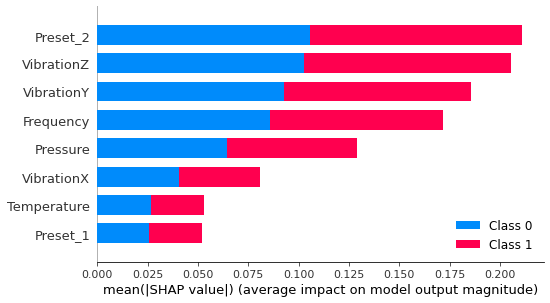

In [35]:
shap.summary_plot(shap_values,x_test)

### It is observed that the feature that presented the greatest impact on the prediction of the model, therefore the model could be greatly impaired if it is to be trained without Preset_2, VibrationZ or VibrationY, for example, because they are the most important features of the model.